<a href="https://colab.research.google.com/github/ajinkyajumde/customer-prediction/blob/main/Final_Customer_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn import ensemble

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data='/content/drive/MyDrive/Almabetter projects/Customer prediction/train_wn75k28.csv'
test_dataset=pd.read_csv(data)

In [6]:
test_dataset.head(5)

,id,created_at,campaign_var_1,campaign_var_2,products_purchased,signup_date,user_activity_var_1,user_activity_var_2,user_activity_var_3,user_activity_var_4,user_activity_var_5,user_activity_var_6,user_activity_var_7,user_activity_var_8,user_activity_var_9,user_activity_var_10,user_activity_var_11,user_activity_var_12,buy
0,1,2021-01-01,1,2,2.0,2020-09-24,0,0,0,0,0,0,1,1,0,0,0,0,0
1,2,2021-01-01,2,1,2.0,2020-09-19,1,0,1,0,0,0,1,0,0,0,0,0,0
2,3,2021-01-01,9,3,3.0,2021-08-11,1,0,0,0,0,0,0,0,0,0,0,0,0
3,4,2021-01-01,6,7,2.0,2017-10-04,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,2021-01-01,4,6,NaN,2020-06-08,0,0,0,0,0,0,1,0,0,0,1,0,0


In [7]:
test_dataset.tail(5)

,id,created_at,campaign_var_1,campaign_var_2,products_purchased,signup_date,user_activity_var_1,user_activity_var_2,user_activity_var_3,user_activity_var_4,user_activity_var_5,user_activity_var_6,user_activity_var_7,user_activity_var_8,user_activity_var_9,user_activity_var_10,user_activity_var_11,user_activity_var_12,buy
39156,39157,2021-12-31,11,11,2.0,2017-10-19,1,0,0,0,1,1,1,0,0,0,0,0,0
39157,39158,2021-12-31,3,9,3.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0
39158,39159,2021-12-31,8,7,2.0,NaN,1,0,0,0,1,0,1,0,0,0,0,0,0
39159,39160,2021-12-31,7,12,2.0,NaN,0,0,0,0,0,1,0,0,0,0,1,0,0
39160,39161,2021-12-31,2,5,NaN,2019-08-11,1,0,0,0,0,0,1,0,0,0,0,0,0


In [8]:
test_dataset.describe()

,id,campaign_var_1,campaign_var_2,products_purchased,user_activity_var_1,user_activity_var_2,user_activity_var_3,user_activity_var_4,user_activity_var_5,user_activity_var_6,user_activity_var_7,user_activity_var_8,user_activity_var_9,user_activity_var_10,user_activity_var_11,user_activity_var_12,buy
count,39161.000000,39161.000000,39161.000000,18250.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000,39161.000000
mean,19581.000000,6.523812,6.452746,2.154137,0.400092,0.006716,0.102832,0.011465,0.151503,0.499834,0.286612,0.174434,0.011440,0.000383,0.218942,0.000562,0.051020
std,11304.951283,3.472944,2.614296,0.779815,0.509194,0.081676,0.303743,0.106463,0.359681,0.558166,0.455784,0.379689,0.106346,0.019568,0.431544,0.023696,0.220042
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9791.000000,4.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,19581.000000,6.000000,6.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,29371.000000,9.000000,8.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,39161.000000,16.000000,15.000000,4.000000,3.000000,1.000000,1.000000,1.000000,2.000000,3.000000,2.000000,2.000000,1.000000,1.000000,4.000000,1.000000,1.000000


In [9]:
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39161 entries, 0 to 39160
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    39161 non-null  int64  
 1   created_at            39161 non-null  object 
 2   campaign_var_1        39161 non-null  int64  
 3   campaign_var_2        39161 non-null  int64  
 4   products_purchased    18250 non-null  float64
 5   signup_date           24048 non-null  object 
 6   user_activity_var_1   39161 non-null  int64  
 7   user_activity_var_2   39161 non-null  int64  
 8   user_activity_var_3   39161 non-null  int64  
 9   user_activity_var_4   39161 non-null  int64  
 10  user_activity_var_5   39161 non-null  int64  
 11  user_activity_var_6   39161 non-null  int64  
 12  user_activity_var_7   39161 non-null  int64  
 13  user_activity_var_8   39161 non-null  int64  
 14  user_activity_var_9   39161 non-null  int64  
 15  user_activity_var_1

In [10]:
test_dataset=test_dataset.drop(columns=['signup_date','id','created_at'],axis=1)

In [11]:
test_dataset=test_dataset.dropna()

In [12]:
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18250 entries, 0 to 39159
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   campaign_var_1        18250 non-null  int64  
 1   campaign_var_2        18250 non-null  int64  
 2   products_purchased    18250 non-null  float64
 3   user_activity_var_1   18250 non-null  int64  
 4   user_activity_var_2   18250 non-null  int64  
 5   user_activity_var_3   18250 non-null  int64  
 6   user_activity_var_4   18250 non-null  int64  
 7   user_activity_var_5   18250 non-null  int64  
 8   user_activity_var_6   18250 non-null  int64  
 9   user_activity_var_7   18250 non-null  int64  
 10  user_activity_var_8   18250 non-null  int64  
 11  user_activity_var_9   18250 non-null  int64  
 12  user_activity_var_10  18250 non-null  int64  
 13  user_activity_var_11  18250 non-null  int64  
 14  user_activity_var_12  18250 non-null  int64  
 15  buy                

In [13]:
test_dataset['buy'].value_counts()

0    17297
1      953
Name: buy, dtype: int64

In [14]:
for i in list(test_dataset.describe()):
  print(f'The Value count for {i} is','\n')
  print(test_dataset[i].value_counts())

The Value count for campaign_var_1 is 

4     2035
5     2016
3     1935
2     1918
6     1900
7     1676
8     1523
9     1188
10     980
1      975
11     718
12     549
13     399
14     240
15     146
16      52
Name: campaign_var_1, dtype: int64
The Value count for campaign_var_2 is 

6     2688
5     2567
7     2488
8     2062
4     2050
3     1539
9     1531
2     1013
10     952
11     541
1      341
12     286
13     143
14      46
15       3
Name: campaign_var_2, dtype: int64
The Value count for products_purchased is 

2.0    8867
3.0    5024
1.0    3643
4.0     716
Name: products_purchased, dtype: int64
The Value count for user_activity_var_1 is 

0    11342
1     6765
2      143
Name: user_activity_var_1, dtype: int64
The Value count for user_activity_var_2 is 

0    18126
1      124
Name: user_activity_var_2, dtype: int64
The Value count for user_activity_var_3 is 

0    16274
1     1976
Name: user_activity_var_3, dtype: int64
The Value count for user_activity_var_4 is 

0

In [15]:
test_dataset=test_dataset.drop(columns=['user_activity_var_2','user_activity_var_3','user_activity_var_4','user_activity_var_9','user_activity_var_10','user_activity_var_12','products_purchased'],axis=1)

In [16]:
buyers=test_dataset[test_dataset['buy']==1]
non_buyers=test_dataset[test_dataset['buy']==0]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

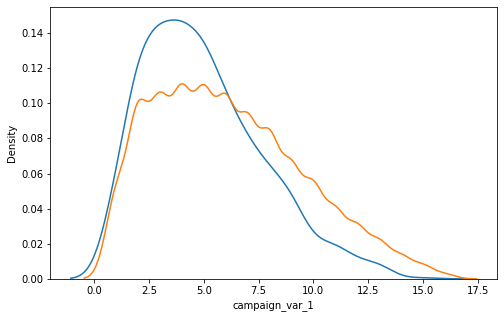

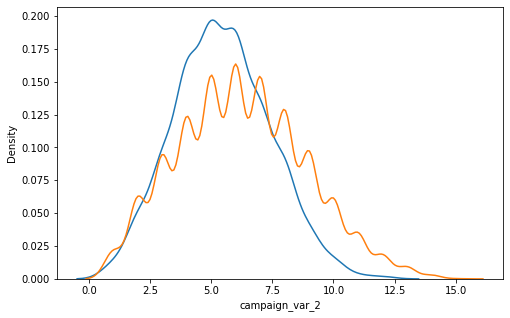

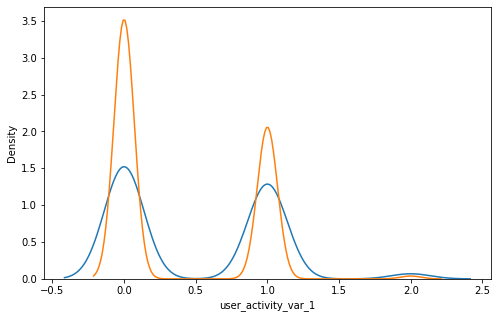

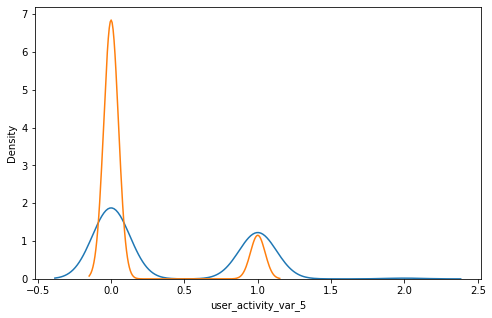

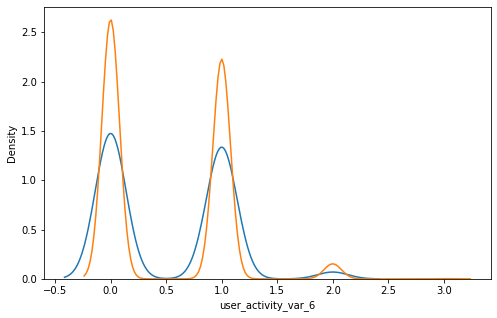

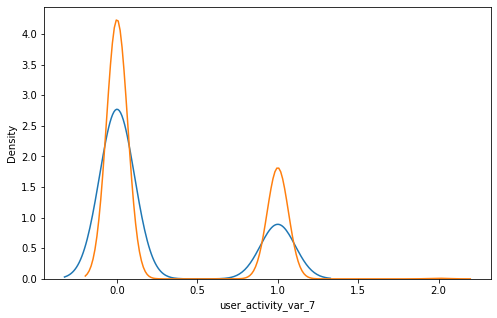

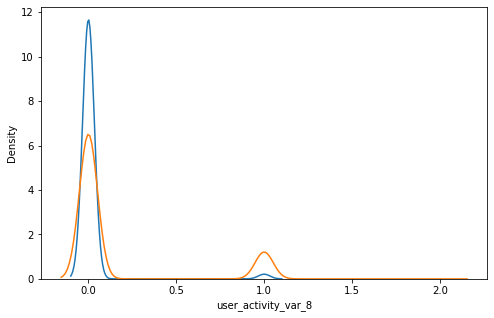

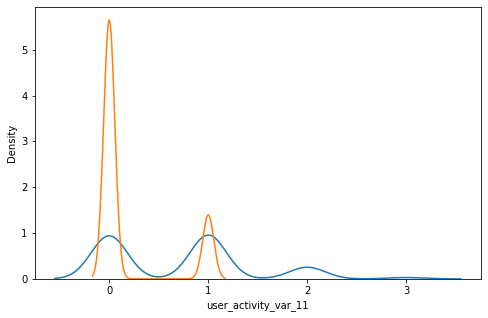

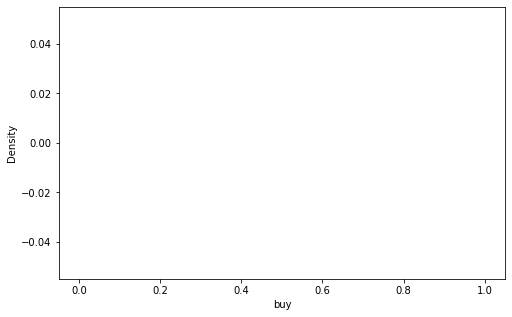

In [17]:
# Distribution plot
for i in list(test_dataset.describe()):
   plt.figure(figsize=(8,5))
   ax = sns.distplot(buyers[i],label='buy',hist=False)
   ax = sns.distplot(non_buyers[i],label='didnt buy',hist=False)
   ax.set(xlabel=i)
plt.show()

In [19]:
lst=list(test_dataset.columns)
lst

['campaign_var_1',
 'campaign_var_2',
 'user_activity_var_1',
 'user_activity_var_5',
 'user_activity_var_6',
 'user_activity_var_7',
 'user_activity_var_8',
 'user_activity_var_11',
 'buy']

In [34]:
test_dataset=pd.get_dummies(test_dataset, columns=['campaign_var_1',
 'campaign_var_2',
 'user_activity_var_1',
 'user_activity_var_5',
 'user_activity_var_6',
 'user_activity_var_7',
 'user_activity_var_8',
 'user_activity_var_11'], prefix=['campaign_var_1',
 'campaign_var_2',
 'user_activity_var_1',
 'user_activity_var_5',
 'user_activity_var_6',
 'user_activity_var_7',
 'user_activity_var_8',
 'user_activity_var_11'])

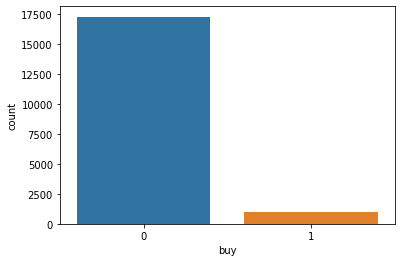

In [35]:
sns.countplot(x=test_dataset['buy'])

In [36]:
# Importing SMOTE
from imblearn.over_sampling import SMOTE

In [37]:
 # Data for all the independent variables
X = test_dataset.drop(labels='buy',axis=1)

 # Data for the dependent variable
Y = test_dataset['buy']

In [38]:
X.shape, Y.shape

((18250, 51), (18250,))

In [39]:
# Train-test split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state=1)

In [40]:
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
Xtrain=X_train
cv = StratifiedKFold(n_splits=5)
X_train, Y_train = SMOTE().fit_resample(X_train, Y_train)

In [41]:
print('Before SMOTE oversampling X_train shape=',Xtrain.shape)
print('After SMOTE oversampling X_train shape=',X_train.shape)

Before SMOTE oversampling X_train shape= (14600, 51)
After SMOTE oversampling X_train shape= (27678, 51)


In [42]:
Y_train.value_counts()

0    13839
1    13839
Name: buy, dtype: int64

In [43]:
# Check the shape of train dataset
print(X_train.shape,Y_train.shape)

# Check the shape of test dataset
print(X_test.shape, Y_test.shape)

(27678, 51) (27678,)
(3650, 51) (3650,)


In [44]:
# Importing XGBoost
from xgboost import XGBClassifier

In [55]:
# Impoting metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [72]:
# hyperparameter tuning with XGBoost

# creating a KFold object 
folds = 5

# specify range of hyperparameters
param_grid = {'learning_rate': [0.01,0.1,0.5,1,10], 
             'subsample': [0.3, 0.6, 0.9,1]}          


# specify model
xgb_model = XGBClassifier()

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, Y_train) 

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=XGBClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 0.5, 1, 10],
                         'subsample': [0.3, 0.6, 0.9, 1]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [73]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,3.412983,0.019802,0.021481,0.001891,0.01,0.3,"{'learning_rate': 0.01, 'subsample': 0.3}",0.837444,0.856022,0.845387,...,0.847177,0.006597,13,0.856435,0.851692,0.842337,0.847796,0.848045,0.849261,0.004668
1,4.158631,0.324370,0.021594,0.003058,0.01,0.6,"{'learning_rate': 0.01, 'subsample': 0.6}",0.823713,0.852893,0.845533,...,0.842945,0.010358,14,0.844320,0.848653,0.843127,0.844507,0.845201,0.845161,0.001869
2,3.137405,0.017715,0.020644,0.001078,0.01,0.9,"{'learning_rate': 0.01, 'subsample': 0.9}",0.821589,0.850485,0.843885,...,0.839880,0.010341,16,0.841926,0.845220,0.841301,0.840649,0.843354,0.842490,0.001632
3,2.806419,0.011016,0.019496,0.000247,0.01,1,"{'learning_rate': 0.01, 'subsample': 1}",0.820831,0.850916,0.845078,...,0.840234,0.010950,15,0.841548,0.845521,0.841730,0.840235,0.843820,0.842571,0.001870
4,3.272092,0.008907,0.018751,0.001424,0.1,0.3,"{'learning_rate': 0.1, 'subsample': 0.3}",0.931526,0.973898,0.975309,...,0.965693,0.017128,12,0.975749,0.964861,0.964445,0.965255,0.964694,0.967001,0.004382
5,3.824678,0.008341,0.018001,0.000575,0.1,0.6,"{'learning_rate': 0.1, 'subsample': 0.6}",0.931245,0.975034,0.976077,...,0.966583,0.017698,11,0.977010,0.965589,0.964626,0.966170,0.965497,0.967778,0.004642
6,3.051518,0.011832,0.017554,0.000400,0.1,0.9,"{'learning_rate': 0.1, 'subsample': 0.9}",0.931379,0.975502,0.977498,...,0.966805,0.017755,10,0.976315,0.965689,0.966246,0.965908,0.964622,0.967756,0.004314
7,2.740681,0.010074,0.017462,0.000234,0.1,1,"{'learning_rate': 0.1, 'subsample': 1}",0.932519,0.975507,0.977355,...,0.967086,0.017320,9,0.977156,0.965797,0.966034,0.966108,0.965134,0.968046,0.004568
8,3.258109,0.005532,0.017229,0.000314,0.5,0.3,"{'learning_rate': 0.5, 'subsample': 0.3}",0.945363,0.993441,0.993460,...,0.983307,0.018990,5,0.992443,0.983232,0.983338,0.983297,0.982674,0.984997,0.003731
9,3.803208,0.006756,0.017077,0.000317,0.5,0.6,"{'learning_rate': 0.5, 'subsample': 0.6}",0.945062,0.993412,0.993064,...,0.983242,0.019110,6,0.992788,0.983254,0.982887,0.983508,0.983206,0.985129,0.003835


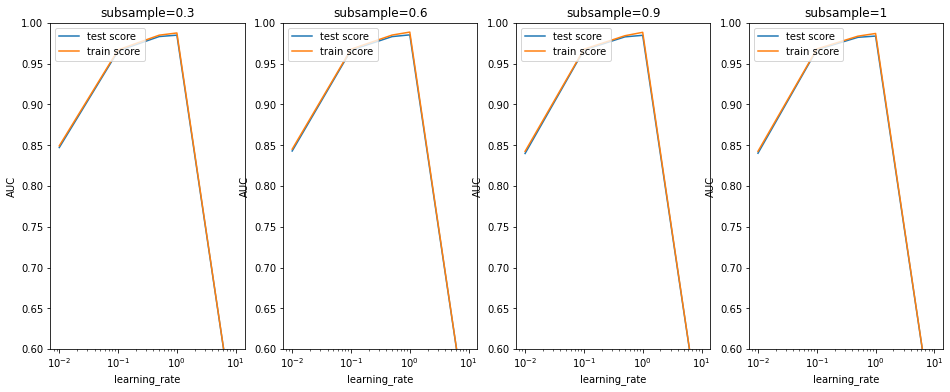

In [74]:
# # plotting
plt.figure(figsize=(16,6))

param_grid = {'learning_rate': [0.01,0.1,0.5,1,10], 
             'subsample': [0.3, 0.6, 0.9,1]} 


for n, subsample in enumerate(param_grid['subsample']):
    

    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('AUC')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

In [75]:
model_cv.best_params_

{'learning_rate': 1, 'subsample': 0.6}

In [76]:
# chosen hyperparameters
# 'objective':'binary:logistic' outputs probability rather than label, which we need for calculating auc
params = {'learning_rate': 1,
           
          
          'subsample':0.6,
         'objective':'binary:logistic'}

# fit model on training data
xgb_imb_model = XGBClassifier(params = params)
xgb_imb_model.fit(X_train, Y_train)

XGBClassifier(params={'learning_rate': 1, 'objective': 'binary:logistic',
                      'subsample': 0.6})

In [77]:
# Predictions on the train set
Y_train_pred = xgb_imb_model.predict(X_train)

In [78]:
# Confusion matrix
confusion = confusion_matrix(Y_train, Y_train_pred)
print(confusion)


[[13456   383]
 [ 1836 12003]]


In [79]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [80]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(Y_train, Y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

# F1 score
print("F1-Score:-", f1_score(Y_train, Y_train_pred))

Accuracy:- 0.9198280222559434
Sensitivity:- 0.8673314545848688
Specificity:- 0.9723245899270179
F1-Score:- 0.9153860819828408


In [81]:
Y_test_pred = xgb_imb_model.predict(X_test)

In [82]:
# Confusion matrix
confusion = confusion_matrix(Y_test, Y_test_pred)
print(confusion)


[[3355  103]
 [ 134   58]]


In [83]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [84]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(Y_train, Y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

# F1 score
print("F1-Score:-", f1_score(Y_train, Y_train_pred))

Accuracy:- 0.9198280222559434
Sensitivity:- 0.3020833333333333
Specificity:- 0.970213996529786
F1-Score:- 0.9153860819828408


In [59]:
# Importing scikit logistic regression module
from sklearn.linear_model import LogisticRegression

In [60]:
# Impoting metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [61]:
# Importing libraries for cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [85]:
# Creating KFold object with 5 splits
folds = KFold(n_splits=5, shuffle=True, random_state=4)

# Specify params
params = {"C": [0.001,0.05,0.01, 0.1, 1, 10, 100,150,250]}

# Specifing score as recall as we are more focused on acheiving the higher sensitivity than the accuracy
model_cv = GridSearchCV(estimator = LogisticRegression(),
                        param_grid = params, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 

# Fit the model
model_cv.fit(X_train, Y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.05, 0.01, 0.1, 1, 10, 100, 150, 250]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [86]:
# results of grid search CV
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.217070,0.010210,0.009232,0.002226,0.001,{'C': 0.001},0.973935,0.973804,0.977937,0.976430,...,0.975390,0.001581,9,0.975951,0.976116,0.974920,0.975178,0.975640,0.975561,0.000452
1,0.372487,0.020807,0.007613,0.000115,0.05,{'C': 0.05},0.978431,0.978398,0.982372,0.980922,...,0.979795,0.001589,7,0.980520,0.980302,0.979577,0.979909,0.980385,0.980139,0.000347
2,0.300114,0.014329,0.007565,0.000172,0.01,{'C': 0.01},0.976256,0.976014,0.980321,0.978815,...,0.977658,0.001655,8,0.978286,0.978307,0.977366,0.977625,0.978089,0.977935,0.000376
3,0.402721,0.026972,0.007816,0.000179,0.1,{'C': 0.1},0.978980,0.979260,0.982897,0.981433,...,0.980397,0.001523,6,0.981126,0.980912,0.980236,0.980551,0.981009,0.980767,0.000328
4,0.539458,0.010083,0.007650,0.000108,1,{'C': 1},0.980205,0.980430,0.983671,0.982305,...,0.981424,0.001352,5,0.982139,0.982204,0.981446,0.981851,0.982204,0.981969,0.000292
5,0.550996,0.007406,0.008222,0.001350,10,{'C': 10},0.980933,0.980518,0.984021,0.982409,...,0.981745,0.001312,4,0.982405,0.982506,0.981690,0.982091,0.982473,0.982233,0.000309
6,0.539560,0.012917,0.008930,0.002733,100,{'C': 100},0.981019,0.980512,0.984070,0.982448,...,0.981784,0.001320,2,0.982438,0.982563,0.981738,0.982161,0.982530,0.982286,0.000308
7,0.543141,0.009263,0.007621,0.000153,150,{'C': 150},0.981014,0.980526,0.984059,0.982459,...,0.981796,0.001308,1,0.982461,0.982574,0.981742,0.982171,0.982531,0.982296,0.000311
8,0.558288,0.017188,0.007693,0.000225,250,{'C': 250},0.980949,0.980411,0.984095,0.982456,...,0.981760,0.001354,3,0.982429,0.982562,0.981756,0.982158,0.982521,0.982285,0.000300


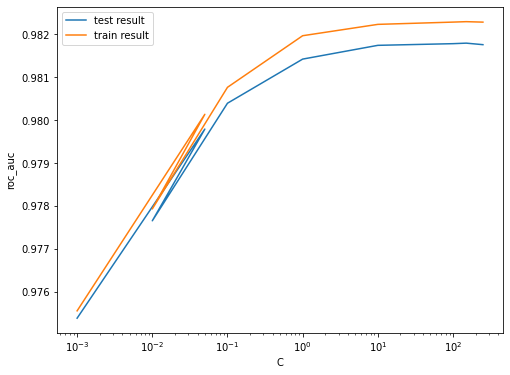

In [87]:
# plot of C versus train and validation scores

plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('roc_auc')
plt.legend(['test result', 'train result'], loc='upper left')
plt.xscale('log')

In [88]:
# Best score with best C
best_score = model_cv.best_score_
best_C = model_cv.best_params_['C']

print(" The highest test roc_auc is {0} at C = {1}".format(best_score, best_C))

 The highest test roc_auc is 0.9817957152620188 at C = 150


In [89]:
# Instantiate the model with best C
logistic_imb = LogisticRegression(C=150)

In [90]:
# Fit the model on the train set
logistic_imb_model = logistic_imb.fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [91]:
# Predictions on the train set
Y_train_pred = logistic_imb_model.predict(X_train)

In [92]:
# Confusion matrix
confusion = metrics.confusion_matrix(Y_train, Y_train_pred)
print(confusion)

[[13532   307]
 [ 1393 12446]]


In [93]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [94]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(Y_train, Y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

# F1 score
print("F1-Score:-", f1_score(Y_train, Y_train_pred))

Accuracy:- 0.9385793771226245
Sensitivity:- 0.8993424380374304
Specificity:- 0.9778163162078185
F1-Score:- 0.9360709987966305
